# Semantic Segmentation of High-Resolution Aerial Images

Hello everyone!



![](https://uavid.nl/UAVid_files/imgs/UAVid_example.png)

Here we will work with [UAVid](https://uavid.nl/#home) dataset, which focusing on urban scenes. Our goal is to predict per-pixel semantic labeling.

And the evaluation metric is IoU.
![](https://www.oreilly.com/library/view/deep-learning-for/9781788295628/assets/63fb2c41-8e83-49c5-ad3a-fee59e8a178b.png)

In this notebook we’ll use the following notable libraries:

* [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) has a lot of encoders for each model architecture.
* [albumentations](https://github.com/albumentations-team/albumentations) has spatial-level transforms that change both an input image and mask simultaneously.
* [catalyst](https://github.com/catalyst-team/catalyst) PyTorch framework that helps with reproducibility, fast experimentation and has a lot of useful utils.
* [wandb](https://www.wandb.com/) Logger to track metrics, save hyper-parameters, gradients and model checkpoints.

# Data overview

First, we’ll install `segmentation-models-pytorch` and `torch nightly` for native amp support. And import libraries.

In [ ]:
# From original file: #Tried: 22.04, 20.03.1, 20.10
# 20.10, training: TypeError: iou() got an unexpected keyword argument 'list_args'
# 20.06, training: AttributeError: 'NoneType' object has no attribute 'astype'
#Untried: 20.04.2, 20.06
# !pip install catalyst==20.06



# From smp catalyst tutorial

# Catalyst
!pip install catalyst==20.12

# for augmentations
!pip install albumentations==0.4.3

# for pretrained segmentation models for PyTorch
!pip install segmentation-models-pytorch==0.1.0

# for TTA
!pip install ttach==0.0.2

# for tensorboard
!pip install tensorflow



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 490 kB 4.7 MB/s 
     |████████████████████████████████| 125 kB 58.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 4.9 MB/s 
     |████████████████████████████████| 631 kB 45.1 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.3-py3-none-any.whl size=60779 sha256=e78048fda62d236306e018751d749bac562cc6aea8b3e39b4af61aee03bd4f3f
  Stored in directory: /root/.cache/pip/wheels/9d/f4/ab/b45b873b6399eeb93386bee4f8bddb9ad0e2f54d34cde20861
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654019 sha256=781fbe3fba74c2cb232f529eefb22b0e0a0cb769ec41d55d593720ce153dfa78
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built albumentations imgaug


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.0 MB/s 
     |████████████████████████████████| 182 kB 63.6 MB/s 
     |████████████████████████████████| 168 kB 48.1 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 166 kB 56.5 MB/s 
     |████████████████████████████████| 166 kB 56.2 MB/s 
     |████████████████████████████████| 162 kB 63.6 MB/s 
     |████████████████████████████████| 162 kB 55.6 MB/s 
     |████████████████████████████████| 158 kB 55.9 MB/s 
     |████████████████████████████████| 157 kB 56.5 MB/s 
     |████████████████████████████████| 157 kB 59.4 MB/s 
     |████████████████████████████████| 157 kB 68.0 MB/s 
     |████████████████████████████████| 157 kB 55.4 MB/s 
     |████████████████████████████████| 157 kB 35.7 MB/s 
     |████████████████████████████████| 157 kB 53.6 MB/s 
     |████████████████████████████

In [ ]:
# !pip install segmentation-models-pytorch
# !pip install --pre torch==1.7.0.dev20200701+cu101 torchvision==0.8.0.dev20200701+cu101 -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.3 MB/s 
     |████████████████████████████████| 58 kB 6.8 MB/s 
     |████████████████████████████████| 376 kB 28.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=b0e2299f2588aa4d4060c302565b5bc1aba6972e102a0ee04792d19be1672f1f
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=bee0ccdb67641b84f6bc1821b587aeb1028ebf880d99caabc08c303bdc87075b
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in li

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["WANDB_SILENT"] = 'True'
import warnings
warnings.filterwarnings('ignore')
import random
import matplotlib.pyplot as plt
import numpy as np
from catalyst import utils
import cv2
import glob
from PIL import Image
import os.path as osp
from tqdm import tqdm
from typing import Callable, List, Tuple
import torch
import catalyst
import wandb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


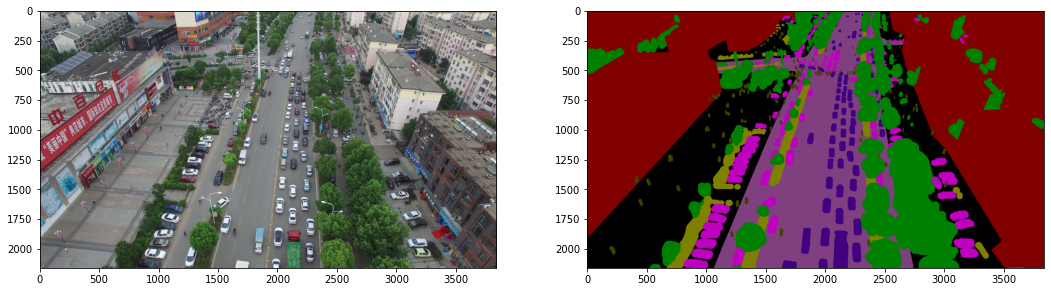

In [ ]:
# def example(image_path = '../input/uavid-semantic-segmentation-dataset/train/train/seq33/Images/000200.png',
            #  mask_path ='../input/uavid-semantic-segmentation-dataset/train/train/seq33/Labels/000200.png'):
def example(image_path = '/content/drive/MyDrive/Bennett/Bennett_Datasets/uavid/data/train/train/seq1/Images/000200.png',
             mask_path ='/content/drive/MyDrive/Bennett/Bennett_Datasets/uavid/data/train/train/seq1/Labels/000200.png'):
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    plt.figure(figsize=(18, 24))
    plt.subplot(1, 2, 1)
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
example()

Dataset comprises 30 video sequences capturing 4K high-resolution images in slanted views. In total, 300 images have been densely labeled with 8 classes.
The image resolution is mostly 3840×2160 or 4096×2160.

![](https://i.ibb.co/r73CD9M/colors.png)

1. building: living houses, garages, skyscrapers, security booths, and buildings under construction.
2. road: road or bridge surface that cars can run on legally. Parking lots are not included.
3. tree: tall trees that have canopies and main trunks.
4. low vegetation: grass, bushes and shrubs.
5. static car: cars that are not moving, including static buses, trucks, automobiles, and tractors. Bicycles and motorcycles are not included.
6. moving car: cars that are moving, including moving buses, trucks, automobiles, and tractors. Bicycles and motorcycles are not included.
7. human: pedestrians, bikers, and all other humans occupied by different activities.
8. clutter: all objects not belonging to any of the classes above.

In [ ]:
import pandas as pd
import seaborn as sns
cls = ['Building', 'Tree', 'Clutter', 'Road', 'Vegetation', 'Static Car', 'Moving Car', 'Human']
pixels = [30.436, 25.977, 17.120, 14.322, 9.464, 1.405, 1.115, 0.162]
pix = pd.DataFrame({'Classes': cls, 'Pixel Number': pixels})

def plot_pixel():
    plt.figure(figsize=(14,12))
    sns.set_palette(['#800000','#008000','#000000', '#804080', '#808000', '#C000C0', '#400080', '#404000'])
    sns.barplot(x='Classes', y='Pixel Number', data=pix)
    plt.title('Pixel Number Histogram')
    plt.ylabel('%')
    plt.xticks(rotation=45)

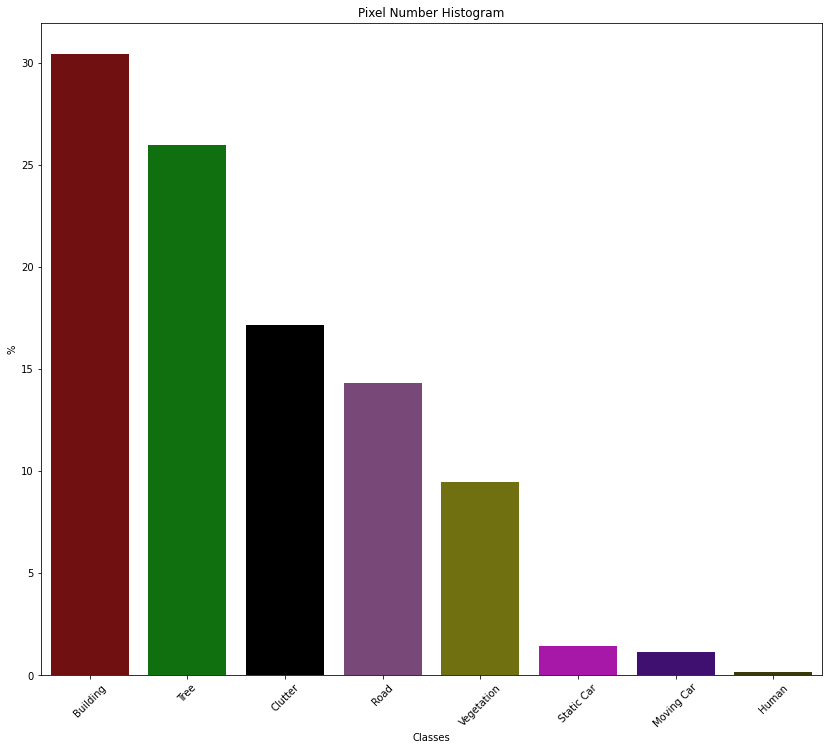

In [ ]:
plot_pixel()

Most of the pixels are from classes like building, tree, clutter, road, and low vegetation. Fewer pixels are from moving
car and static car classes, which are both fewer than 1.5% of
the total pixels. For human class, it is almost zero, fewer
than 0.2% of the total pixels.

# Data Preparation

We’ll need helper functions for label image conversion from 3 channel RGB color image to 1 channel label index image

In [ ]:
class UAVidColorTransformer:
    def __init__(self):
    # color table.
        self.clr_tab = self.createColorTable()
    # id table.
        id_tab = {}
        for k, v in self.clr_tab.items():
            id_tab[k] = self.clr2id(v)
        self.id_tab = id_tab

    def createColorTable(self):
        clr_tab = {}
        clr_tab['Clutter'] = [0, 0, 0]
        clr_tab['Building'] = [128, 0, 0]
        clr_tab['Road'] = [128, 64, 128]
        clr_tab['Static_Car'] = [192, 0, 192]
        clr_tab['Tree'] = [0, 128, 0]
        clr_tab['Vegetation'] = [128, 128, 0]
        clr_tab['Human'] = [64, 64, 0]
        clr_tab['Moving_Car'] = [64, 0, 128]
        return clr_tab

    def colorTable(self):
        return self.clr_tab

    def clr2id(self, clr):
        return clr[0]+clr[1]*255+clr[2]*255*255

  #transform to uint8 integer label
    def transform(self,label, dtype=np.int32):
        height,width = label.shape[:2]
    # default value is index of clutter.
        newLabel = np.zeros((height, width), dtype=dtype)
        id_label = label.astype(np.int64)
        id_label = id_label[:,:,0]+id_label[:,:,1]*255+id_label[:,:,2]*255*255
        for tid,val in enumerate(self.id_tab.values()):
            mask = (id_label == val)
            newLabel[mask] = tid
        return newLabel

  #transform back to 3 channels uint8 label
    def inverse_transform(self, label):
        label_img = np.zeros(shape=(label.shape[0], label.shape[1],3),dtype=np.uint8)
        values = list(self.clr_tab.values())
        for tid,val in enumerate(values):
            mask = (label==tid)
            label_img[mask] = val
        return label_img

In [ ]:
clrEnc = UAVidColorTransformer()
def prepareTrainIDForDir(gtDirPath, saveDirPath):
    gt_paths = [p for p in os.listdir(gtDirPath) if p.startswith('seq')]
    for pd in tqdm(gt_paths):
        lbl_dir = osp.join(gtDirPath, pd, 'Labels')
        lbl_paths = os.listdir(lbl_dir)
        if not osp.isdir(osp.join(saveDirPath, pd, 'TrainId')):
            os.makedirs(osp.join(saveDirPath, pd, 'TrainId'))
            assert osp.isdir(osp.join(saveDirPath, pd, 'TrainId')), 'Fail to create directory:%s'%(osp.join(saveDirPath, pd, 'TrainId'))
        for lbl_p in lbl_paths:
            lbl_path = osp.abspath(osp.join(lbl_dir, lbl_p))
            trainId_path = osp.join(saveDirPath, pd, 'TrainId', lbl_p)
            gt = np.array(Image.open(lbl_path))
            trainId = clrEnc.transform(gt, dtype=np.uint8)
            Image.fromarray(trainId).save(trainId_path)

If we use joblib.Parallel, we can speedup ~3x

In [ ]:
# prepareTrainIDForDir('../input/uavid-semantic-segmentation-dataset/train/train', './trainlabels/')
# prepareTrainIDForDir('../input/uavid-semantic-segmentation-dataset/valid/valid', './validlabels/')

# prepareTrainIDForDir('/content/drive/MyDrive/Bennett/Bennett_Datasets/uavid/data/train/train', '/content/drive/MyDrive/Bennett/Bennett_Datasets/uavid/labels/trainlabels')
# prepareTrainIDForDir('/content/drive/MyDrive/Bennett/Bennett_Datasets/uavid/data/train/train', '/content/drive/MyDrive/Bennett/Bennett_Datasets/uavid/labels/validlabels')

After creating label images, we’ll define lists of images and labels for our Dataset.

In [ ]:
# train_image_list = sorted(glob.glob(pathname='../input/uavid-semantic-segmentation-dataset/train/train/*/Images/*.png', recursive=True))
# train_mask_list =  sorted(glob.glob(pathname='./trainlabels/*/TrainId/*.png', recursive=True))
# valid_image_list = sorted(glob.glob(pathname='../input/uavid-semantic-segmentation-dataset/valid/valid/*/Images/*.png', recursive=True))
# valid_mask_list =  sorted(glob.glob(pathname='./validlabels/*/TrainId/*.png', recursive=True))
# print(train_image_list[42])
# print(train_mask_list[42])

train_image_list = sorted(glob.glob(pathname='/content/drive/MyDrive/Bennett/Bennett_Datasets/uavid/data/train/train/*/Images/*.png', recursive=True))
train_mask_list =  sorted(glob.glob(pathname='/content/drive/MyDrive/Bennett/Bennett_Datasets/uavid/labels/trainlabels/*/TrainId/*.png', recursive=True))
valid_image_list = sorted(glob.glob(pathname='/content/drive/MyDrive/Bennett/Bennett_Datasets/uavid/data/valid/valid/*/Images/*.png', recursive=True))
valid_mask_list =  sorted(glob.glob(pathname='/content/drive/MyDrive/Bennett/Bennett_Datasets/uavid/labels/validlabels/*/TrainId/*.png', recursive=True))


print(train_image_list[42])
print(train_mask_list[42])

/content/drive/MyDrive/Bennett/Bennett_Datasets/uavid/data/train/train/seq1/Images/file11-2.png
/content/drive/MyDrive/Bennett/Bennett_Datasets/uavid/labels/trainlabels/seq1/TrainId/file11-2.png


# Dataset

Set seed and mix precision training.

In [ ]:
SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)
is_fp16_used = True

In our Dataset, we can read images, extract values of classes from segmentation mask, apply augmentation and pre-processing transformations.

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):

    CLASSES = ['clutter', 'building', 'road', 'static_car', 'tree', 'vegetation', 'human', 'moving_car']

    def __init__(
            self,
            images_list,
            masks_list,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.images_list = images_list
        self.masks_list = masks_list
        self.classes = classes

        # convert str names to class values on masks
        if self.classes is not None:
            self.class_values = np.array([self.CLASSES.index(cls.lower()) for cls in classes]) / 255

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_list[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_list[i], 0)
        mask = mask.astype('float') / 255

        # extract certain classes from mask (e.g. cars)
        if self.classes is not None:
            masks = [(mask == v) for v in self.class_values]
            mask = np.stack(masks, axis=-1).astype('float')
        else:
            mask = np.expand_dims(mask, 2)
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']


        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.images_list)

Helper functions for visualization.

In [ ]:
def visualize(image, mask, label=None, truth=None,  augment=False):
    if truth is None:
        plt.figure(figsize=(14, 20))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        if augment == False:
            plt.title(f"{'Original Image'}")
        else:
            plt.title(f"{'Augmented Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        if label is not None:
            plt.title(f"{label.capitalize()}")

    else:
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

        plt.subplot(1, 3, 3)
        plt.imshow(truth)
        plt.title(f"{'Ground Truth'}")

def visualize_overlay(image, mask, truth_path=None):
    if truth_path is None:
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

    else:
        truth = Image.open(truth_path)
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

        plt.subplot(1, 3, 3)
        plt.imshow(truth)
        plt.title(f"{'Ground Truth'}")

def visualize_prediction(image, mask):
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

Visualizing segmentation masks for all classes.

In [ ]:
labels = ['clutter', 'building', 'road', 'static_car', 'tree', 'vegetation', 'human', 'moving_car']
for label in labels:
    dataset = Dataset(train_image_list, train_mask_list, classes=[label])

    image, mask = dataset[4]
    visualize(
        image=image, mask=mask.squeeze(),
        label = label)

We'll resize images to `576*1024` to keep 9:16 ratio.

Augmentation list:
* *HorizontalFlip*
* *OneOf(RandomBrightnessContrast, CLAHE, HueSaturationValue)*
* *IAAAdditiveGaussianNoise* with 0.2 probability

*Note:* For better result we could crop each image into 16 evenly distributed smaller(1280*720) overlapped images that cover the whole image for training.

In [ ]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.Resize(576, 1024, p=1),
        albu.HorizontalFlip(p=0.5),

        albu.OneOf([
            albu.RandomBrightnessContrast(
                  brightness_limit=0.4, contrast_limit=0.4, p=1),
            albu.CLAHE(p=1),
            albu.HueSaturationValue(p=1)
            ],
            p=0.9,
        ),

        albu.IAAAdditiveGaussianNoise(p=0.2),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [albu.Resize(576, 1024, p=1),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

Visualizing augmented images and masks.

In [ ]:
labels = ['clutter', 'building', 'road', 'static_car', 'tree', 'vegetation', 'human', 'moving_car']
for label in labels:
    augmented_dataset = Dataset(
        train_image_list,
        train_mask_list,
        augmentation=get_training_augmentation(),
        classes=[label],
    )

# same image with different random transforms
    image, mask = augmented_dataset[8]
    visualize(
        image=image, mask=mask.squeeze(),
        label = label, augment=True)

# Model Creation

## Single Model

In our experiments, we'll use FPN model with EfficientnetB3 encoder. The motivation was to select best model in Memory Consumption, Accuracy trade-off.

In [ ]:
import segmentation_models_pytorch as smp

ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
CLASSES = ['clutter', 'building', 'road', 'static_car', 'tree', 'vegetation', 'human', 'moving_car']

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

We’ll define Dataloaders and set batch size to 6, because of memory limitation.

In [ ]:
batch_size = 6

train_dataset = Dataset(
    train_image_list,
    train_mask_list,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    valid_image_list,
    valid_mask_list,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

Selecting optimization level: **01** - Mixed Precision (recommended for typical use)

In [ ]:
if is_fp16_used:
    fp16_params = dict(opt_level="O1")
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")

FP16 params: {'opt_level': 'O1'}


Experiment settings:
* Loss: BCEDiceLoss with 0.5 contibution of BCE and Dice
* Optimizer: Lookahead(improves the learning stability and lowers the variance of its inner optimizer)
* Scheduler: OneCycleLRWithWarmup with 2 warmup steps
* Initial learning rate is set to 1e-3, and 1e-4 on encoder. Number of epochs to 30.

In [ ]:
from catalyst.contrib.nn import BCEDiceLoss, RAdam, Lookahead, OneCycleLRWithWarmup
from catalyst.dl import SupervisedRunner

logdir = "./logs"
num_epochs = 30
# num_epochs = 2
learning_rate = 1e-3
base_optimizer = RAdam([
    {'params': model.decoder.parameters(), 'lr': learning_rate},
    {'params': model.encoder.parameters(), 'lr': 1e-4},
    {'params': model.segmentation_head.parameters(), 'lr': learning_rate},
])
optimizer = Lookahead(base_optimizer)
criterion = BCEDiceLoss(activation=None)
runner = SupervisedRunner()
scheduler = OneCycleLRWithWarmup(
    optimizer,
    num_steps=num_epochs,
    lr_range=(0.0016, 0.0000001),
    init_lr = learning_rate,
    warmup_steps=2
)

Importing callbacks for metrics and logging

In [ ]:
from catalyst.dl.callbacks import IouCallback, WandbLogger, EarlyStoppingCallback, ClasswiseIouCallback

callbacks = [
    IouCallback(activation = 'none'),
    ClasswiseIouCallback(classes=CLASSES, activation = 'none'),
    EarlyStoppingCallback(patience=7, metric='iou', minimize=False),
    WandbLogger(project='Project_Name', name='Run_Name'),

]

ImportError: ignored

Model training, set main_metric to **'iou'**

In [ ]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=callbacks,
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    # prints train logs
    verbose=True,
)

![](https://i.ibb.co/qjGFnbw/single.png)

In [ ]:
cls = ['Building', 'Tree', 'Clutter', 'Road', 'Vegetation', 'Static Car', 'Moving Car', 'Human']
s_iou = [85.64, 72.85, 55.86, 69.78, 54.93, 0, 0, 0]
sing_iou = pd.DataFrame({'Classes': cls, 'IoU': s_iou})
single_iou = sing_iou.pivot_table(values='IoU', columns='Classes')
single_iou

Classes,Building,Clutter,Human,Moving Car,Road,Static Car,Tree,Vegetation
IoU,85.64,55.86,0.0,0.0,69.78,0.0,72.85,54.93


In [ ]:
batch = next(iter(loaders['valid']))
dataset = Dataset(valid_image_list, valid_mask_list, augmentation=get_validation_augmentation())
image, _ = dataset[0]
truth_path='../input/uavid-semantic-segmentation-dataset/valid/valid/seq16/Labels/000000.png'

In [ ]:
from catalyst.utils import mask_to_overlay_image

# pred = mask_to_overlay_image(image=image, masks=single[0], threshold=0.4)
pred = mask_to_overlay_image(image=image, masks=single[0], threshold=0.4)
visualize_overlay(image, pred, truth_path=truth_path)

NameError: ignored

As we can see, we’ve shown strong results in most pixels classes. But we’re not able to identify cars and people.

To address this problem, we create 3 additional models for static car, moving car and human classes.

## Clutter, Building, Road, Tree, Vegetation

New experiment settings:
* Loss: The same
* Optimizer: The same
* Scheduler: ReduceLROnPlateau with patience 3 and factor 0.3
* Number of epochs changed to 40. Added weight decay. Learning rate is set to 1.5e-3. Batch size reduced to 5.

In [ ]:
import segmentation_models_pytorch as smp

ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
CLASSES = ['clutter', 'building', 'road', 'tree', 'vegetation']

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

logdir = "./logs"
num_epochs = 40
learning_rate = 1.5e-3
base_optimizer = RAdam([
    {'params': model.decoder.parameters(), 'lr': learning_rate, 'weight_decay': 1e-3},
    {'params': model.encoder.parameters(), 'lr': 1e-4, 'weight_decay': 1e-4},
    {'params': model.segmentation_head.parameters(), 'lr': learning_rate},
])
optimizer = Lookahead(base_optimizer)
scheduler = ReduceLROnPlateau(optimizer, factor=0.3, patience=3, mode='max')
criterion = BCEDiceLoss(activation=None)
runner = SupervisedRunner()

![](https://i.ibb.co/hRhzVBf/cls5.png)

In [ ]:
cls = ['Building', 'Tree', 'Clutter', 'Road', 'Vegetation']
s_iou = [85.64, 72.85, 55.86, 69.78, 54.93]
cls5_iou = [86.79, 74.16, 58.01, 71.08, 53.59]
sing_iou = pd.DataFrame([s_iou, cls5_iou], columns=cls, index=['single', 'top5'])
sing_iou

As we can see from the table, we’ve improved previous results in 4 of 5 classes.

In [ ]:
pred5 = mask_to_overlay_image(image=image, masks=cls5[0], threshold=0.4)
visualize_overlay(image, pred5, truth_path=truth_path)

## Moving Car

Here we try several learning rates: 3e-4, 7e-4, 1e-3, 1.5e-3, 3e-3

![](https://i.ibb.co/XphB6s2/mc.png)

In [ ]:
dataset = Dataset(valid_image_list, valid_mask_list, augmentation=get_validation_augmentation(), classes=['moving_car'])
image, ground_truth = dataset[0]

grs2 = mask_to_overlay_image(image=image, masks=mc[0], threshold=0.4)
visualize(image, grs2, truth=ground_truth.squeeze())

### Static Car

![](https://i.ibb.co/cXKMJRS/sc.png)

In [ ]:
dataset = Dataset(valid_image_list, valid_mask_list, augmentation=get_validation_augmentation(), classes=['static_car'])
image, ground_truth = dataset[0]

grs3 = mask_to_overlay_image(image=image, masks=sc[0], threshold=0.4)
visualize(image, grs3, truth=ground_truth.squeeze())

### Human

![](https://i.ibb.co/VVDpYxt/hum.png)

In [ ]:
dataset = Dataset(valid_image_list, valid_mask_list, augmentation=get_validation_augmentation(), classes=['human'])
image, ground_truth = dataset[0]

grs4 = mask_to_overlay_image(image=image, masks=hum[0], threshold=0.4)
visualize(image, grs4, truth=ground_truth.squeeze())

## Ensemble

In [ ]:
cls = ['Building', 'Tree', 'Clutter', 'Road', 'Vegetation', 'Static Car', 'Moving Car', 'Human', 'mIoU']
ensemble = [86.79, 74.16, 58.01, 71.08, 53.59, 51.34, 39.27, 22.21, 57.06]
final = pd.DataFrame([ensemble], columns=cls, index=['ensemble'])
final

In [ ]:
dataset = Dataset(valid_image_list, valid_mask_list, augmentation=get_validation_augmentation())
image, _ = dataset[0]
image1, _ = dataset[1]
image2, _ = dataset[2]
image3, _ = dataset[3]
image4, _ = dataset[4]
images = [image, image1, image2, image3, image4]
full = [[cls5[i][0], cls5[i][1], cls5[i][2], sc[i][0], cls5[i][3], cls5[i][4], hum[i][0], mc[i][0]]  for i in range(5)]
full_truth1 = [mask_to_overlay_image(image=images[i], masks=full[i], threshold=0.4) for i in range(5)]

In [ ]:
for i in range(5):
    visualize_prediction(images[i], full_truth1[i])